# Batch training example

This notebooks illustrates a simple approach to batch training in Edward. To that end, we extend the [supervised learning example](http://edwardlib.org/tutorials/supervised-regression), where the task is to infer hidden structure from
labeled data, comprised of training examples $\{(x_n, y_n)\}$. 
Regression typically means the output $y$ takes continuous values.

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import Counter

from edward.models import Normal

plt.style.use('ggplot')

/Users/mmt/anaconda/envs/mnist-uncertainty/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Data

Simulate training and test sets of $N$ data points. They comprise of
pairs of inputs $\mathbf{x}_n\in\mathbb{R}^{10}$ and outputs
$y_n\in\mathbb{R}$. They have a linear dependence with normally
distributed noise. For a training set of size $N$ and batches of size $M$, we have $\frac{N}{M}$ batches.

In [2]:
def build_toy_dataset(N, w):
    D = len(w)
    x = np.random.normal(0.0, 2.0, size=(N, D))
    y = np.dot(x, w) + np.random.normal(0.0, 0.05, size=N)
    return x, y

In [3]:
# Helper function to select the next batch
def next_batch(t):
    return train_list[t][:, :D], train_list[t][:, D]

In [4]:
ed.set_seed(42)

N = 417  # number of data points
M = 10   # (approximate) batch size
D = 10   # number of features

w_true = np.ones(D) * 5
X_train, y_train = build_toy_dataset(N, w_true)
X_test, y_test = build_toy_dataset(N, w_true)

# split data into roughly equal-sized batches
train = np.column_stack((X_train, y_train))
np.random.shuffle(train) # shuffle

n_batches = N // M
train_list = np.array_split(train, n_batches)

In [5]:
# Batch sizes ({size: frequency})
Counter([len(arr) for arr in train_list])

Counter({10: 34, 11: 7})

## Model

Posit the model as Bayesian linear regression (Murphy, 2012).
It assumes a linear relationship between the inputs
$\mathbf{x}\in\mathbb{R}^D$ and the outputs $y\in\mathbb{R}$.

For a set of $N$ data points $(\mathbf{X},\mathbf{y})=\{(\mathbf{x}_n, y_n)\}$,
the model posits the following distributions:

\begin{align*}
  p(\mathbf{w})
  &=
  \text{Normal}(\mathbf{w} \mid \mathbf{0}, \sigma_w^2\mathbf{I}),
  \\[1.5ex]
  p(b)
  &=
  \text{Normal}(b \mid 0, \sigma_b^2),
  \\
  p(\mathbf{y} \mid \mathbf{w}, b, \mathbf{X})
  &=
  \prod_{n=1}^N
  \text{Normal}(y_n \mid \mathbf{x}_n^\top\mathbf{w} + b, \sigma_y^2).
\end{align*}

The latent variables are the linear model's weights $\mathbf{w}$ and
intercept $b$, also known as the bias.
Assume $\sigma_w^2,\sigma_b^2$ are known prior variances and $\sigma_y^2$ is a
known likelihood variance. The mean of the likelihood is given by a
linear transformation of the inputs $\mathbf{x}_n$.

Let's build the model in Edward, fixing $\sigma_w,\sigma_b,\sigma_y=1$. 

In [6]:
X = tf.placeholder(tf.float32, [None, D])
y_ph = tf.placeholder(tf.float32, [None])

w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=ed.dot(X, w) + b, scale=1.0)

Here, we define a placeholder `X`. During inference, we pass in
the value for this placeholder according to batches of data.
To enable training with batches of varying size, 
we don't fix the number of rows for $X$ and $y$.

## Inference

We now turn to inferring the posterior using variational inference.
Define the variational model to be a fully factorized normal across
the weights.

In [7]:
qw = Normal(loc=tf.Variable(tf.random_normal([D])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

Run variational inference with the Kullback-Leibler divergence, using 
$10$ iterations and $5$ latent variable samples per batch. We iterate over the number of batches and feed them to the respective placeholder. We scale each batch to avoid the inference being dominated by the prior. 

As an interesting aside, increasing the iterations per batch to, e.g., $100$ leads to batch-wise overfitting and slow improvement.

In [8]:
avg_loss = 0.0
inference = ed.KLqp({w: qw, b: qb}, data={y: y_ph})
inference.initialize(n_iter = 10, n_samples = 5, scale={X: N / M, y: N / M})
tf.global_variables_initializer().run()

for t in range(1, int(n_batches) + 1):
    X_batch, y_batch = next_batch(t - 1)
    for _ in range(inference.n_iter):
        info_dict = inference.update({X: X_batch, y_ph: y_batch})
        avg_loss += info_dict['loss']
    avg_loss = avg_loss / n_batches
    if t % 5 == 0:
        print("Loss after {} batches: \tlog p(x) >= {:0.3f}".format(t, avg_loss))

Loss after 5 batches: 	log p(x) >= 10878.377
Loss after 10 batches: 	log p(x) >= 968.799
Loss after 15 batches: 	log p(x) >= 565.674
Loss after 20 batches: 	log p(x) >= 168.088
Loss after 25 batches: 	log p(x) >= 166.168
Loss after 30 batches: 	log p(x) >= 157.768
Loss after 35 batches: 	log p(x) >= 153.873
Loss after 40 batches: 	log p(x) >= 146.835


In this case, `KLqp` defaults to minimizing the
$\text{KL}(q\|p)$ divergence measure using the reparameterization
gradient.
For more details on inference, see the [$\text{KL}(q\|p)$ tutorial](http://edwardlib.org/tutorials/klqp).

## Criticism

A standard evaluation for regression is to compare prediction accuracy on
held-out "testing" data. We do this by first forming the posterior predictive
distribution.

In [9]:
y_post = ed.copy(y, {w: qw, b: qb})
# This is equivalent to
# y_post = Normal(loc=ed.dot(X, qw) + qb, scale=tf.ones(N))

With this we can evaluate various quantities using predictions from
the model (posterior predictive).

In [10]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X: X_test, y_post: y_test}))

Mean squared error on test data:
0.0103304
Mean absolute error on test data:
0.0869914


The trained model makes predictions with low error
(relative to the magnitude of the output).

We can also visualize the fit by comparing data generated with the
prior to data generated with the posterior (on the first feature
dimension).

In [11]:
def visualise(X_data, y_data, w, b, n_samples=10, dim=50):
    w_samples = w.sample(n_samples)[0].eval()
    b_samples = b.sample(n_samples).eval()
    plt.scatter(X_data[:, 0], y_data)
    plt.axis([-dim, dim, -dim, dim])
    inputs = np.linspace(-8, 8, num=400)
    for ns in range(n_samples):
        output = inputs * w_samples[ns] + b_samples[ns]
        plt.plot(inputs, output)

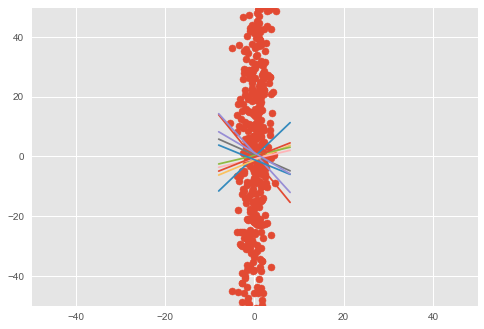

In [12]:
# Visualize samples from the prior.
visualise(X_train, y_train, w, b)

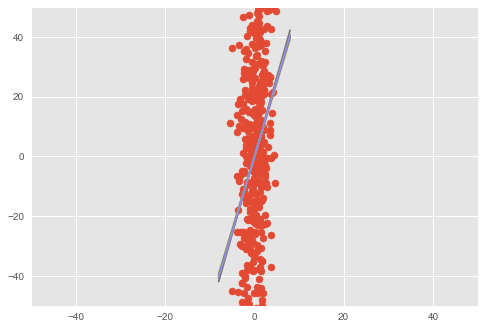

In [13]:
# Visualize samples from the posterior.
visualise(X_train, y_train, qw, qb)

The model has learned a linear relationship between the
first dimension of $\mathbf{x}\in\mathbb{R}^D$ and the outputs
$y\in\mathbb{R}$.